In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from google.colab import drive

try:
    drive.mount('/content/drive')
except:
    pass

project_root = "/content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2"
src_dir = os.path.join(project_root, "src")
data_dir = os.path.join(project_root, "data")
results_dir = os.path.join(project_root, "results")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(os.path.join(results_dir, "figures"), exist_ok=True)
os.makedirs(os.path.join(results_dir, "metrics"), exist_ok=True)

import sys
if src_dir not in sys.path:
    sys.path.append(src_dir)

print("Project root:", project_root)
print("Src dir     :", src_dir)
print("Data dir    :", data_dir)
print("Results dir :", results_dir)

train_csv = os.path.join(data_dir, "mitbih_train.csv")
test_csv = os.path.join(data_dir, "mitbih_test.csv")

print("Train CSV   :", os.path.exists(train_csv))
print("Test CSV    :", os.path.exists(test_csv))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project root: /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2
Src dir     : /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2/src
Data dir    : /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2/data
Results dir : /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2/results


In [ ]:
def make_transform(aug_fns):
    """
    aug_fns: [jitter, scaling, ...]
    """
    def _transform(x: torch.Tensor) -> torch.Tensor:
        # x shape: (1, 187)
        arr = x.squeeze(0).cpu().numpy()  # (187,)
        for fn in aug_fns:
            arr = fn(arr)
        return torch.from_numpy(arr).float().unsqueeze(0)
    return _transform

In [ ]:
AUG_CONFIGS = [
    ("baseline",           []),
    ("jitter",             [jitter]),
    ("scaling",            [scaling]),
    ("jitter_scaling",     [jitter, scaling]),
    ("time_warp",          [time_warp]),
    ("magnitude_warp",     [magnitude_warp]),
]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)           # (B, num_classes)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

    return running_loss / total, correct / total

Using device: cpu


In [ ]:
results = []

NUM_EPOCHS = 5 
BATCH_SIZE = 256

for aug_name, aug_fns in AUG_CONFIGS:
    print(f"\n===== Experiment: {aug_name} =====")

    if len(aug_fns) == 0:
        train_transform = None
    else:
        train_transform = make_transform(aug_fns)

    train_loader, val_loader, test_loader = create_dataloaders(
        data_dir,
        batch_size=BATCH_SIZE,
        transform=train_transform,
        val_ratio=0.2,
        seed=42,
    )

    model = ECGClassifier(num_classes=5).to(device)   # num_classes=5 (MIT-BIH)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0.0
    best_test_acc = 0.0

    history = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss,   val_acc   = evaluate(model, val_loader, criterion, device)
        test_loss,  test_acc  = evaluate(model, test_loader, criterion, device)

        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        print(
            f"[{aug_name}] Epoch {epoch:02d} | "
            f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Test Acc: {test_acc:.3f}"
        )

    exp_result = {
        "augmentation": aug_name,
        "best_val_acc": best_val_acc,
        "best_test_acc": best_test_acc,
        "history": history,
    }
    results.append(exp_result)

    json_path = os.path.join(results_dir, f"aug_experiment_{aug_name}.json")
    with open(json_path, "w") as f:
        json.dump(exp_result, f, indent=2)

summary_path = os.path.join(results_dir, "aug_experiments_summary.json")
with open(summary_path, "w") as f:
    json.dump(results, f, indent=2)

print("\n=== All experiments done ===")
for r in results:
    print(f"{r['augmentation']:>16} | best_val_acc={r['best_val_acc']:.3f}, best_test_acc={r['best_test_acc']:.3f}")


===== Experiment: baseline =====
[baseline] Epoch 01 | Train Acc: 0.938 | Val Acc: 0.967 | Test Acc: 0.965
[baseline] Epoch 02 | Train Acc: 0.964 | Val Acc: 0.971 | Test Acc: 0.969
[baseline] Epoch 03 | Train Acc: 0.969 | Val Acc: 0.976 | Test Acc: 0.974
[baseline] Epoch 04 | Train Acc: 0.972 | Val Acc: 0.977 | Test Acc: 0.975
[baseline] Epoch 05 | Train Acc: 0.973 | Val Acc: 0.975 | Test Acc: 0.973

===== Experiment: jitter =====
[jitter] Epoch 01 | Train Acc: 0.934 | Val Acc: 0.960 | Test Acc: 0.960
[jitter] Epoch 02 | Train Acc: 0.961 | Val Acc: 0.967 | Test Acc: 0.967
[jitter] Epoch 03 | Train Acc: 0.964 | Val Acc: 0.973 | Test Acc: 0.972
[jitter] Epoch 04 | Train Acc: 0.967 | Val Acc: 0.975 | Test Acc: 0.972
[jitter] Epoch 05 | Train Acc: 0.969 | Val Acc: 0.977 | Test Acc: 0.974

===== Experiment: scaling =====
[scaling] Epoch 01 | Train Acc: 0.942 | Val Acc: 0.965 | Test Acc: 0.965
[scaling] Epoch 02 | Train Acc: 0.966 | Val Acc: 0.975 | Test Acc: 0.972
[scaling] Epoch 03 | Trai

In [ ]:
summary_rows = []
for r in results:
    summary_rows.append({
        "augmentation": r["augmentation"],
        "best_val_acc": r["best_val_acc"],
        "best_test_acc": r["best_test_acc"],
    })

df_results = pd.DataFrame(summary_rows)
df_results = df_results.sort_values("best_test_acc", ascending=False)
df_results

,augmentation,best_val_acc,best_test_acc
2,scaling,0.978356,0.976795
5,magnitude_warp,0.976643,0.976201
0,baseline,0.976986,0.974648
1,jitter,0.976815,0.974237
3,jitter_scaling,0.974131,0.972593
4,time_warp,0.826052,0.827608


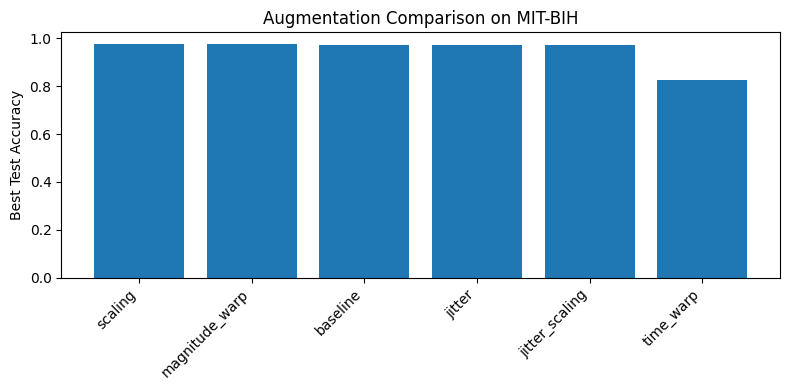

Saved figure to: /content/drive/MyDrive/Colab Notebooks/ecg-augmentation-repro-minkuek2/results/figures/aug_comparison.png


In [ ]:
plt.figure(figsize=(8, 4))
plt.bar(df_results["augmentation"], df_results["best_test_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Best Test Accuracy")
plt.title("Augmentation Comparison on MIT-BIH")
plt.tight_layout()

fig_path = os.path.join(results_dir, "figures", "aug_comparison.png")
plt.savefig(fig_path, dpi=150)
plt.show()

print("Saved figure to:", fig_path)